### We use icesat data to validate the dem data (aster dem, coregistrated dem, icesat-corrected dem)
### Cross validation: 
1. the dem at 2005 is validated on the stable region by using glah14 data at 2003, 2004, 2006, 2007, 2008.
2. the dem at 2020 is validated on the stable region by using atl data at 2019, 2021.  
#### -- **however, in this demo, we used glah14 2009 evaluate the dem 2009; or use alt06 2020 to evaluate the dem 2009.**


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from utils.raster_vec import vec2mask
from matplotlib.colors import LinearSegmentedColormap
from utils.geotif_io import readTiff
from utils.transform_xy import geo2imagexy
import statistics


In [3]:
### --- remove icesat points which 1) outside the given image extent; 2) locate in the water region; 
#       the masked icesat point is with the image coordinates system.
def icesat_mask(lon, lat, h, mask_img, mask_img_geotrans):
    row, col = geo2imagexy(x=lon, y=lat, gdal_trans=mask_img_geotrans, integer=False)
    idx_in = np.where((row<mask_img.shape[0]) & (col<mask_img.shape[1]))[0]
    row_, col_, h_ = row[idx_in], col[idx_in], h[idx_in]    
    mask_icesat = mask_img[row_.astype('int'), col_.astype('int')]
    valid_idx = np.where((mask_icesat==1))[0]
    row_, col_, h_ = row_[valid_idx], col_[valid_idx], h_[valid_idx]
    return row_, col_, h_


In [4]:
path_dem = 'data/aster-stereo/2009-36-78/dem.tif'
path_dem_coreg = 'data/aster-stereo/2009-36-78/dem_coreg.tif'
path_dem_correct = 'data/aster-stereo/2009-36-78/dem_correct.tif'
path_glah14 = 'data/icesat/glah14-readout/tile-36-78/GLAH14_2009_subs.H5'
path_atl06 = 'data/icesat/atl06-readout/tile-36-78/ATL06_2020.h5'
path_water_jrc = 'data/water_jrc/water_jrc_36_78.tif'   ### jrc water map for water mask
path_rgi = 'data/rgi60/rgi60_36_78.gpkg'                ### rgi glacier data for glacier mask



Text(0.5, 1.0, 'dem_correct')

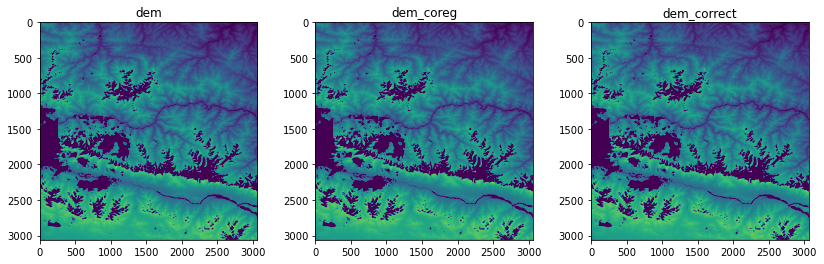

In [5]:
### 1.read dem images
dem = xdem.DEM(path_dem)        # 
dem_coreg=xdem.DEM(path_dem_coreg)
dem_correct=xdem.DEM(path_dem_correct)
### --2.water/glacier mask
water_jrc = xdem.DEM(path_water_jrc).reproject(dem)
rgi60_mask = vec2mask(path_vec=path_rgi, path_raster=path_dem, path_save=None)
mask_img = np.where(water_jrc.data[0]+rgi60_mask==0, 1, 0)   # stable region (non-water and non-glacier region)
mask_img[np.isnan(dem_coreg.data[0])]=0 
mask_img[np.isnan(dem_correct.data[0])]=0 
dem_masked=np.copy(dem.data[0]);  dem_masked[mask_img ==0] = 0
dem_coreg_masked=np.copy(dem_coreg.data[0]); dem_coreg_masked[mask_img ==0] = 0
dem_correct_masked=np.copy(dem_correct.data[0]); dem_correct_masked[mask_img ==0] = 0
### --3. visualize
plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.imshow(dem_masked, vmin=2000, vmax=7000);plt.title('dem')
plt.subplot(1,3,2); plt.imshow(dem_coreg_masked, vmin=2000, vmax=7000);plt.title('dem_coreg')
plt.subplot(1,3,3); plt.imshow(dem_correct_masked, vmin=2000, vmax=7000);plt.title('dem_correct')


In [6]:
### Read one-year/full-region glas14/icesat data
with h5py.File(path_glah14, 'r') as f_glah14_tile:
    glah14_lat_tile = f_glah14_tile['h_lat'][:]
    glah14_lon_tile = f_glah14_tile['h_lon'][:]
    glah14_h_tile = f_glah14_tile['h_cor'][:]
    glah14_t_tile = f_glah14_tile['t_dyr'][:]
    print(f_glah14_tile.keys())

### Read one-tile/one-year ATL06 data
with h5py.File(path_atl06, 'r') as f_atl06_tile:
    atl06_lat_tile   = f_atl06_tile['h_lat'][:]
    atl06_lon_tile   = f_atl06_tile['h_lon'][:]
    atl06_h_tile = f_atl06_tile['h_li'][:]
    atl06_time_tile = f_atl06_tile['t_dyr'][:]
    atl06_beam_tile = f_atl06_tile['beam_type'][:]
    atl06_spot_tile = f_atl06_tile['spot'][:]    # 1->strong; 0->weak
    atl06_rgt_tile = f_atl06_tile['rgt'][:]   
    print(f_atl06_tile.keys())
    

<KeysViewHDF5 ['h_cor', 'h_lat', 'h_lon', 'h_orbit', 'h_track', 't_dyr']>
<KeysViewHDF5 ['beam_type', 'cycle', 'h_lat', 'h_li', 'h_lon', 'orbit_type', 'rgt', 'spot', 't_dyr']>


In [7]:
# lat_altimetry, lon_altimetry, h_altimetry = atl06_lat_tile, atl06_lon_tile, atl06_h_tile
lat_altimetry, lon_altimetry, h_altimetry = glah14_lat_tile, glah14_lon_tile, glah14_h_tile



### visualize the icesat data on the dem image

Text(0.5, 1.0, 'dem-altimetry')

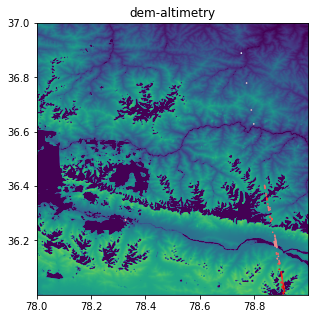

In [8]:
cmap = LinearSegmentedColormap.from_list('linear color', ['LightCyan', 'Red'])
_, dem_info = readTiff(path_dem)
extent_tandem = dem_info['geoextent']
plt.figure(figsize=(5, 5))
plt.imshow(dem_masked,vmin=2000, vmax=7000, extent=extent_tandem); 
plt.scatter(x=lon_altimetry, y=lat_altimetry, c=h_altimetry, s=0.5, cmap=cmap)
plt.title('dem-altimetry')


### Calculate difference between the icesat data and dem image

In [9]:
### 1. icesat filter with mask image
row_altimetry_mask, col_altimetry_mask, h_altimetry_mask = icesat_mask(lon_altimetry, \
                                        lat_altimetry, h_altimetry, mask_img, dem_info['geotrans'])
row_altimetry_mask, col_altimetry_mask, h_altimetry_mask = np.floor(row_altimetry_mask).astype('int'), \
                            np.floor(col_altimetry_mask).astype('int'), np.floor(h_altimetry_mask).astype('int')

### 2. obtain dem/dem-coreg/dem-correct height at the altimetry points.
h_dem = dem_masked[row_altimetry_mask, col_altimetry_mask]
h_dem_coreg = dem_coreg_masked[row_altimetry_mask, col_altimetry_mask]
h_dem_correct = dem_correct_masked[row_altimetry_mask, col_altimetry_mask]

### 3. calculate the difference between dem image and icesat data
h_dif_dem = h_altimetry_mask-h_dem
h_dif_dem_coreg = h_altimetry_mask-h_dem_coreg
h_dif_dem_correct = h_altimetry_mask-h_dem_correct
### -- remove outlier values: 1. remove the points of |h_dif| < 100; 
###                           2. remove the value out the range of 5%~95%
idx_valid = np.where((h_dif_dem<100) & (h_dif_dem > -100))      ## remove the points of |h_dif| < 100 
h_dif_dem_valid, h_dif_dem_coreg_valid, h_dif_dem_correct_valid = h_dif_dem[idx_valid], \
                                            h_dif_dem_coreg[idx_valid], h_dif_dem_correct[idx_valid]
idx_valid =  np.where((h_dif_dem_valid>np.nanpercentile(h_dif_dem_valid, 5)) & (h_dif_dem_valid<np.nanpercentile(h_dif_dem_valid, 95)))
h_dif_dem_valid, h_dif_dem_coreg_valid, h_dif_dem_correct_valid = h_dif_dem_valid[idx_valid], \
                                            h_dif_dem_coreg_valid[idx_valid], h_dif_dem_correct_valid[idx_valid]

print('h_dif_dem mean',statistics.mean(h_dif_dem_valid),'h_dif_dem variance:', statistics.variance(h_dif_dem_valid))
print('h_dif_dem_coreg mean',statistics.mean(h_dif_dem_coreg_valid),'h_dif_dem_coreg variance:', statistics.variance(h_dif_dem_coreg_valid))
print('h_dif_dem_correct mean',statistics.mean(h_dif_dem_correct_valid),'h_dif_dem_correct variance:', statistics.variance(h_dif_dem_correct_valid))



h_dif_dem mean 25.421949065133425 h_dif_dem variance: 143.04298877364465
h_dif_dem_coreg mean 6.926829134480337 h_dif_dem_coreg variance: 134.83287591988696
h_dif_dem_correct mean -2.585808571804775 h_dif_dem_correct variance: 118.31617816075668


25.421949065133425 6.926829134480337 -2.585808571804775


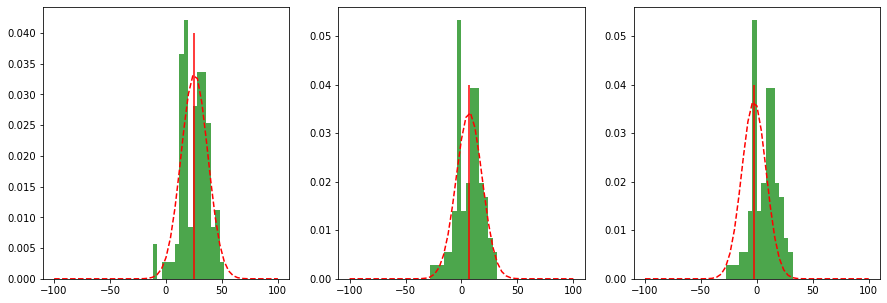

In [10]:
num_bins = 50
mean_dif_dem, sigma_dif_dem = statistics.mean(h_dif_dem_valid), statistics.stdev(h_dif_dem_valid)
mean_dif_dem_coreg, sigma_dif_dem_coreg = statistics.mean(h_dif_dem_coreg_valid), statistics.stdev(h_dif_dem_coreg_valid)
mean_dif_dem_correct, sigma_dif_dem_correct = statistics.mean(h_dif_dem_correct_valid), statistics.stdev(h_dif_dem_correct_valid)
print(mean_dif_dem, mean_dif_dem_coreg, mean_dif_dem_correct)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
n, bins, patches = plt.hist(h_dif_dem_valid, num_bins, \
                              density = 1, color ='green', alpha = 0.7, range=[-100, 100])
y = ((1 / (np.sqrt(2 * np.pi) * sigma_dif_dem)) * np.exp(-0.5 * (1 / sigma_dif_dem * (bins - mean_dif_dem))**2))  
plt.plot(bins, y, '--', color ='red'); plt.vlines(x=mean_dif_dem, ymin=0, ymax=0.04, colors='red')

plt.subplot(1,3,2)
n, bins, patches = plt.hist(h_dif_dem_coreg_valid, num_bins, \
                              density = 1, color ='green', alpha = 0.7,range=[-100, 100])
y = ((1 / (np.sqrt(2 * np.pi) * sigma_dif_dem_coreg)) * np.exp(-0.5 * (1 / sigma_dif_dem_coreg * (bins - mean_dif_dem_coreg))**2))  
plt.plot(bins, y, '--', color ='red'); plt.vlines(x=mean_dif_dem_coreg, ymin=0, ymax=0.04, colors='red')

plt.subplot(1,3,3)
n, bins, patches = plt.hist(h_dif_dem_coreg_valid, num_bins, \
                              density = 1, color ='green', alpha = 0.7,range=[-100, 100])
y = ((1 / (np.sqrt(2 * np.pi) * sigma_dif_dem_correct)) * np.exp(-0.5 * (1 / sigma_dif_dem_correct * (bins - mean_dif_dem_correct))**2))  
plt.plot(bins, y, '--', color ='red'); plt.vlines(x=mean_dif_dem_correct, ymin=0, ymax=0.04, colors='red')

